# Sarcasm Detection
Sarcasm is one of the many kinds of social information that people regularly use in text. But despite the prevalence in everyday talk, it can be *really* hard to detect in text. The same goes for a neural network, and it is often far more challenging than other natural language processing topics. Luckily for us in today's age, we can help give each other and computers an indication of when sarcasm is used, such as emojis or TypYIng lIkE thIS, or using `\s` after a sarcastic comment. 

What makes sarcasm so hard to identify is that it often is very subtle of carries contrasting notions (positives with negatives). In the article *Why is sarcasm so difficult to detect in texts and emails?* on [The Conversation](https://theconversation.com/why-is-sarcasm-so-difficult-to-detect-in-texts-and-emails-91892) by Sara Peters uses this example:

Frank: I'm waiting at the front. Movie starts in 5.

Mike: I'm on my way now. Should be there in 10.

Frank: I'm glad you were watching the clock today.

In a real-life conversation, for most of us, sarcasm would be pretty easy to detect. We could be personally invested in this person and know that Mike is often late, so Frank poked at Mike with sarcasm. But what if the comment was sincere? Through text, this is much more ambiguous. 

For this project, we will be working with different sarcasm to help interpret this nuanced version and the less so. The [SARC 2.0](https://nlp.cs.princeton.edu/SARC/2.0/main/) are the sarcasm labels we will use; these come from user comments labeled `\s` at the end of comments on Reddit. We will start by loading the dependencies and gzip files and then looking into what the datasets entail.

In [1]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

import bz2
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import Counter
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
train_df = pd.read_csv('assets/sarcasm.train.tsv.gz', sep='\t', compression='gzip').dropna()
test_imb_df = pd.read_csv('assets/sarcasm.test-imb.tsv.gz', sep='\t', compression='gzip').dropna()
test_bal_df = pd.read_csv('assets/sarcasm.test-bal.tsv.gz', sep='\t', compression='gzip').dropna()

The datasets contain two columns, text for the text of the comment and a label for the binary value of sarcasm. 1 being sarcasm is present and 0 being no sarcasm. Based on the dataset explanation, comments with label 1 would have had `\s` included in the comment. 

In [4]:
train_df.head()

,text,label
0,Religion must have the answer,1
1,It's obviously tracks from a giant water tract...,0
2,Wow...he smoked pot...oh lord hes such a horri...,1
3,"Wow, his girlfriend is uhm... Ah fuck it, he's...",0
4,I think the government should track every morm...,0


# Convert the training/test corpus to TFIDF feature vectors
Next, we need to convert the training and test corpus to TFIDF feature vectors. We will be using `TfidfVectorizer` to featurize SARC 2.0, with a document frequency of `10`, use English stopwords, and use unigrams and bigrams as the vectorizer. 

In [5]:
vectorizer = TfidfVectorizer(min_df=10, stop_words='english', ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df.text)

X_test_bal = vectorizer.transform(test_bal_df.text)
X_test_imb = vectorizer.transform(test_imb_df.text)

y_train = list(train_df.label)
y_test_bal = list(test_bal_df.label)
y_test_imb = list(test_imb_df.label)

X_train.shape, X_test_bal.shape, X_test_imb.shape

((257081, 17205), (64665, 17205), (1682352, 17205))

# Train model and evaluate
We will initialize a `LogisticRegression` setting the `multi_class` to auto. We will also initialize a `RandomForestClassifier` that will let us use conjunctive features. To speed up training, we will limit the number of decision tree estimators to `50` and restrict their depth to `15`. Lastly, we will create a `DummyClassifier` used as the baseline for the performance comparison. The data that we are using is balanced and makes it suitable to apply the dummy classifier.

In [6]:
lr_clf = LogisticRegression(multi_class='auto').fit(X_train, y_train)
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=15).fit(X_train, y_train)
random_clf = DummyClassifier().fit(X_train, y_train).fit(X_train, y_train) # Dummy baseline

C:\Users\Logan\anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [7]:
y_pred_bal = lr_clf.predict(X_test_bal)
y_pred_imb = lr_clf.predict(X_test_imb)

rf_y_pred_bal = rf_clf.predict(X_test_bal)
rf_y_pred_imb = rf_clf.predict(X_test_imb)

random_y_pred_bal = random_clf.predict(X_test_bal)
random_y_pred_imb = random_clf.predict(X_test_imb)

# Score the predictions
Using the f1 score, we will evaluate how each of the models performs on both y test sets, `y_test_bal` and `y_test_imb`.

In [8]:
score_list = []
# Test y_test_imb with the three models
score_list.append((('LogisticRegression' , 'y_test_imb'), f1_score(y_test_imb, y_pred_imb, average='binary')))
score_list.append((('RandomForestClassifier' , 'y_test_imb'), f1_score(y_test_imb, rf_y_pred_imb, average='binary')))
score_list.append((('DummyClassifier' , 'y_test_imb'), f1_score(y_test_imb, random_y_pred_imb, average='binary')))

# Test y_test_bal with the three models
score_list.append((('LogisticRegression' , 'y_test_bal'), f1_score(y_test_bal, y_pred_bal, average='binary')))
score_list.append((('RandomForestClassifier' , 'y_test_bal'), f1_score(y_test_bal, rf_y_pred_bal, average='binary')))
score_list.append((('DummyClassifier' , 'y_test_bal'), f1_score(y_test_bal, random_y_pred_bal, average='binary')))

for item in score_list:
    print('{} on {} scored: {}'.format(item[0][0], item[0][1], item[1]))

LogisticRegression on y_test_imb scored: 0.0984097150941826
RandomForestClassifier on y_test_imb scored: 0.11630926177327305
DummyClassifier on y_test_imb scored: 0.0503142809441514
LogisticRegression on y_test_bal scored: 0.628169014084507
RandomForestClassifier on y_test_bal scored: 0.49050374878189446
DummyClassifier on y_test_bal scored: 0.5014615134784021


# Examining predictions
Creating a `make_pipeline`, we can pass in the `vectorizer` created by `TfidfVectorizer` and the `LogisticRegression` and `RandomForestClassifier` to find the predicted score of sarcasm (0 being no sarcasm and 1 being absolute sarcasm). We call these `rf_pipe` and `lr_pipe`; below, we have an example with a random phrase from the test dataframe, but any text can be imputed by setting a custom value the `inst_text`.

In [9]:
rf_pipe = make_pipeline(vectorizer, rf_clf)  
lr_pipe = make_pipeline(vectorizer, lr_clf)

## Phrase from test dataframe

In [10]:
test_row_df = test_imb_df.sample(1)
_, inst_text, label = next(test_row_df.itertuples())

print('Comment has text "%s"' %(inst_text))
print('True label: %d' % label)
print('LogisticRegression Probability(Sarcastic) =', lr_pipe.predict_proba([inst_text])[0, 1])
print('RandomForest Probability(Sarcastic) =', rf_pipe.predict_proba([inst_text])[0, 1])

Comment has text "Or.....I dunno......always fucking record not just when the escalation point is reached."
True label: 0
LogisticRegression Probability(Sarcastic) = 0.2528171083561147
RandomForest Probability(Sarcastic) = 0.46762094898958106


## Imput own phrase

In [11]:
inst_text = 'You guys give up, or are you thirsty for more?'

print('LogisticRegression Probability(Sarcastic) =', lr_pipe.predict_proba([inst_text])[0, 1])
print('RandomForest Probability(Sarcastic) =', rf_pipe.predict_proba([inst_text])[0, 1])

LogisticRegression Probability(Sarcastic) = 0.6812749484293568
RandomForest Probability(Sarcastic) = 0.5069121933760886


# Evaluating predictions with Lime
Lime is a way for data scientists to explain the individual predictions for text classifiers. We will create a `LimeTextExplainer` passing in two classes, 'sarcastic' and 'non-sarcastic'. We can then use our `inst_test` and pipelines to determine the influence individual words make on the overall sarcasm scale. Using the quote "You guys give up, or are you thirsty for more?" from Home Alone, we see that the word "guys" heavily influences both models to think that the overall sentiment is between 50% through 70% sarcastic. Interestingly the other words play a minimal role except for "thirsty" having a negative effect on logistic regression, implying more people might use this word less sarcastically.

In [12]:
lime_classes = ['sarcastic', 'non-sarcastic']
explainer = LimeTextExplainer(class_names=lime_classes)

In [13]:
inst_text = 'You guys give up, or are you thirsty for more?'

rf_explanation = explainer.explain_instance(inst_text, rf_pipe.predict_proba, num_features=10)
lr_explanation = explainer.explain_instance(inst_text, lr_pipe.predict_proba, num_features=10)

In [14]:
for feat, val in rf_explanation.as_list():
    print('RandomForestClassifier has an estimated weight of %f on feature "%s"' % (val, feat))
    
for feat, val in lr_explanation.as_list():
    print('LogisticRegression has an estimated weight of %f on feature "%s"' % (val, feat))

RandomForestClassifier has an estimated weight of 0.011751 on feature "guys"
RandomForestClassifier has an estimated weight of 0.000002 on feature "or"
RandomForestClassifier has an estimated weight of 0.000002 on feature "up"
RandomForestClassifier has an estimated weight of 0.000002 on feature "thirsty"
RandomForestClassifier has an estimated weight of 0.000001 on feature "for"
RandomForestClassifier has an estimated weight of 0.000001 on feature "You"
RandomForestClassifier has an estimated weight of 0.000001 on feature "are"
RandomForestClassifier has an estimated weight of 0.000001 on feature "more"
RandomForestClassifier has an estimated weight of 0.000001 on feature "you"
RandomForestClassifier has an estimated weight of 0.000001 on feature "give"
LogisticRegression has an estimated weight of 0.254910 on feature "guys"
LogisticRegression has an estimated weight of -0.049464 on feature "thirsty"
LogisticRegression has an estimated weight of 0.003854 on feature "or"
LogisticRegres

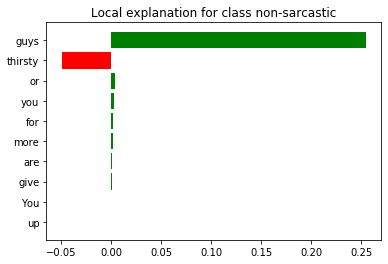

In [15]:
fig = lr_explanation.as_pyplot_figure()

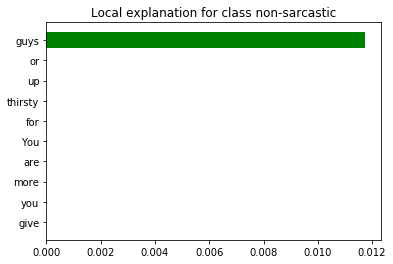

In [16]:
fig = rf_explanation.as_pyplot_figure()